使用的 seeds: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]

【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0     20
   eig1     20

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig1003      2
eig3643      1
eig1549      1
 eig926      1
eig3763      1
eig3557      1
eig4030      1
eig3679      1
eig1656      1
eig1473      1
eig1014      1
eig1775      1
eig1512      1
eig1434      1
 eig954      1
 eig673      1
eig3672      1
eig1237      1
eig1657      1
eig3957      1
eig1798      1
eig3821      1
eig3883      1
 eig579      1
 eig914      1
eig1251      1
eig1264      1
eig1585      1
eig3863      1
eig3864      1
 eig999      1
eig1419      1
eig1974      1
eig3742      1
eig3346      1
eig3956      1
eig3674      1
eig3835      1
eig1255      1
eig1645      1
eig3922      1
eig4032      1
eig1286      1
eig1617      1
eig3798      1
eig3965      1
eig4296      1
ei

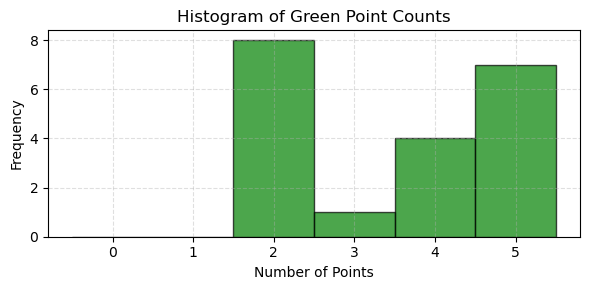

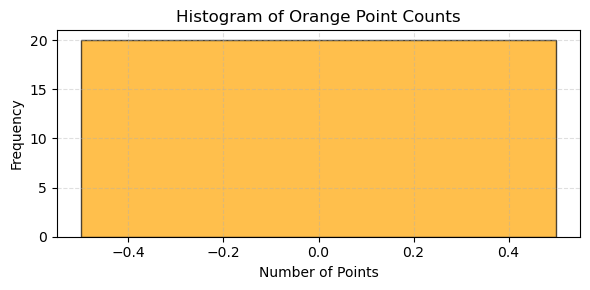

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_64976/3952044529.py:169: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_64976/3952044529.py:169: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


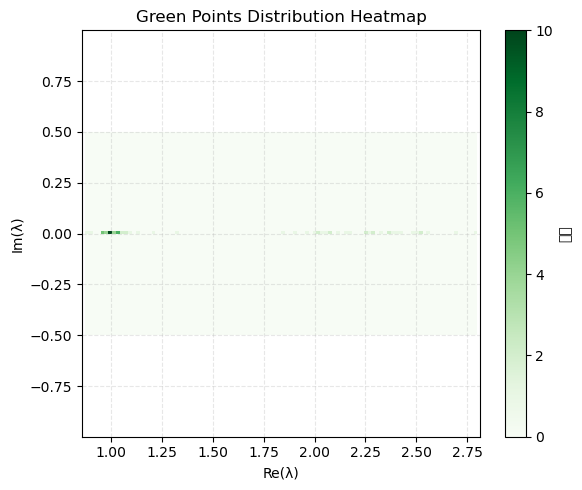

In [3]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 5, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15
jump_margin = 0.1

num_trials = 20
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=500)[:num_trials]
noise = np.random.randint(0, 100, size=num_trials)
seeds = (base_seeds + noise).tolist()
print("使用的 seeds:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 计数器与记录器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

green_count_list = []
orange_count_list = []
green_coords = []  # 新增：记录绿色点坐标（Re, Im）

# ========== 单轮运行函数 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点（前2最大实部）
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点（Re > α/αc）排除红点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # ===== 绿色点判别机制（堆积带右跳跃） =====
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))

    # ✅ 新增：记录绿色点坐标
    green_coords.extend(list(zip(green_pts["Re"], green_pts["Im"])))

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 打印稳定谱点 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# ========== 显示绿色/橙色数量直方分布 ==========
green_series = pd.Series(green_count_list, name="GreenCount")
orange_series = pd.Series(orange_count_list, name="OrangeCount")

print("\n[绿色点数量直方分布 across trials]")
print(green_series.value_counts().sort_index().to_string())

print("\n[橙色点数量直方分布 across trials]")
print(orange_series.value_counts().sort_index().to_string())

def plot_histogram(counts, title, color):
    plt.figure(figsize=(6, 3))
    plt.hist(counts, bins=np.arange(-0.5, max(counts) + 1.5, 1), edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Number of Points")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_histogram(green_count_list, "Histogram of Green Point Counts", "green")
plot_histogram(orange_count_list, "Histogram of Orange Point Counts", "orange")

# ========== 新增：绿色点坐标热力图 ==========
def plot_green_point_heatmap(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]

    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap")
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# ✅ 调用可视化函数
plot_green_point_heatmap(green_coords)



【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：
 Re_q  Im_q  count
0.995   0.0      5
0.955   0.0      4
1.005   0.0      3
1.025   0.0      3
0.980   0.0      3
1.015   0.0      2
2.010   0.0      2
1.040   0.0      2
0.990   0.0      2
1.000   0.0      2
2.365   0.0      1
2.075   0.0      1
1.080   0.0      1
1.050   0.0      1
2.510   0.0      1
1.965   0.0      1
2.260   0.0      1
1.905   0.0      1
2.060   0.0      1
2.155   0.0      1

【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：False

【标准二】在 A 区间 [0.95, 1.05] 内出现 ≥2 个绿色点的轮次：12/20，比例=0.60

【标准三】每轮 A/B 区绿色点数量：
 seed  A_count  B_count
   51        2        0
  592        2        0
 1014        2        0
 1571        2        0
 2060        2        0
 2520        1        0
 3082        2        0
 3586        2        0
 4074        1        0
 4574        2        0
 5087        2        0
 5599        1        0
 6023        0        0
 6502        1        0
 7021        1        0
 7552        0        1
 8001        2        0
 8587    

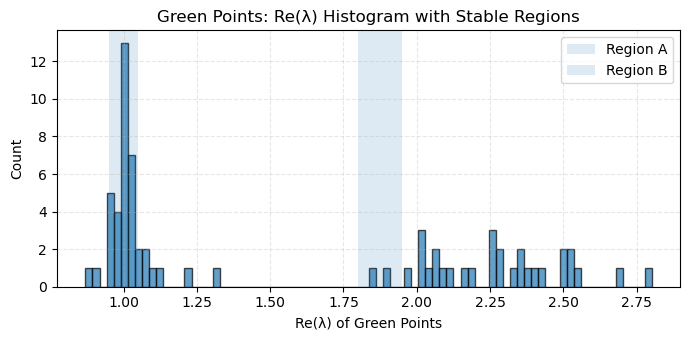

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_64976/108180099.py:134: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_64976/108180099.py:134: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


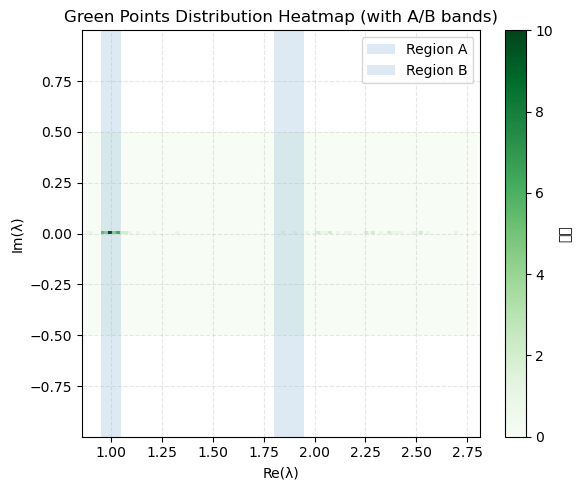


========== 稳定性评估小结 ==========
标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。
标准二：超过半数轮次 (>10.0) 在 A 区间出现 ≥2 个绿色点？ -> 12 轮，比例 0.60
标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。


In [5]:
# ======= 新增：评估参数（容差与网格步长） =======
real_tol = 1e-6           # 认为“近似实轴”的虚部阈值
bin_width_re = 0.005      # 绿色点坐标网格化（实部）步长，用于“标准一”的跨轮次计数
bin_width_im = 0.005      # 绿色点坐标网格化（虚部）步长

# 稳定区间（标准二/三）
A_min, A_max = 0.95, 1.05
B_min, B_max = 1.80, 1.95

# ======= 工具函数：坐标网格化（用于标准一） =======
def quantize_coord(x, w):
    return np.round(x / w) * w

def bucketize_point(re, im, w_re, w_im):
    return (quantize_coord(re, w_re), quantize_coord(im, w_im))

# ======= 新增：跨轮次绿色点“桶”计数（标准一） =======
green_bucket_counter = Counter()
# 每轮 A/B 区绿色点计数（标准三）
per_trial_counts = []  # list of dicts：{"seed":..., "A_count":..., "B_count":..., "A_coords":..., "B_coords":...}
# 每轮 A 区是否达到 ≥2（标准二）
A_ge2_flags = []

# ======= 修改：在 run_single_trial 内部，我们已把 green_coords 追加了 (Re, Im)
# 这里在主循环结束后，做三套标准的统计 =======

# ---- 标准一：同一点跨轮次重现（用网格化坐标近似“同一点”） ----
for (re, im) in green_coords:
    key = bucketize_point(re, im, bin_width_re, bin_width_im)
    green_bucket_counter[key] += 1

# 构造 DataFrame 便于查看跨轮次高频“同一点”
bucket_items = []
for (re_q, im_q), cnt in green_bucket_counter.items():
    bucket_items.append({"Re_q": re_q, "Im_q": im_q, "count": cnt})
bucket_df = pd.DataFrame(bucket_items).sort_values("count", ascending=False)

print("\n【标准一】绿色点跨轮次“同一网格点”出现次数（按频次降序，显示前20条）：")
print(bucket_df.head(20).to_string(index=False) if not bucket_df.empty else "无绿色点可统计")

# 粗判结论（是否存在明显“固定点”）
fixed_like_exists = (not bucket_df.empty) and (bucket_df["count"].max() >= num_trials * 0.8)
print(f"\n【标准一结论】是否存在近似固定的绿色点（同一网格点在 ≥80% 轮次出现）：{fixed_like_exists}")

# ---- 标准二 & 三：按稳定区间统计 ----
# 我们按“每轮”的绿色点坐标重建（需要把 green_coords 按 trial 切片）
# 为此在 run_single_trial 中增加每轮绿色点数量 green_count_list，这里利用它切片
trial_slices = []
start = 0
for k in range(num_trials):
    cnt = green_count_list[k]
    trial_slices.append((start, start + cnt))
    start += cnt

A_ge2 = 0
A_ge2_seeds = []
regionA_coords_all = []
regionB_coords_all = []

for k, (lo, hi) in enumerate(trial_slices):
    seed_k = seeds[k]
    coords_k = green_coords[lo:hi]
    # A/B 区筛选（近似实轴）
    Ak = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (A_min <= re <= A_max))]
    Bk = [(re, im) for (re, im) in coords_k if (abs(im) < real_tol and (B_min <= re <= B_max))]
    per_trial_counts.append({
        "seed": seed_k,
        "A_count": len(Ak),
        "B_count": len(Bk),
        "A_coords": Ak,
        "B_coords": Bk,
    })
    regionA_coords_all.extend(Ak)
    regionB_coords_all.extend(Bk)

    # 标准二：本轮 A 区是否有 ≥2 个绿色点
    flag = (len(Ak) >= 2)
    A_ge2_flags.append(flag)
    if flag:
        A_ge2 += 1
        A_ge2_seeds.append(seed_k)

ratio_A_ge2 = A_ge2 / num_trials
print(f"\n【标准二】在 A 区间 [{A_min}, {A_max}] 内出现 ≥2 个绿色点的轮次：{A_ge2}/{num_trials}，比例={ratio_A_ge2:.2f}")

# ---- 标准三：每轮 A/B 区计数与“进入子空间评估”的种子清单 ----
per_trial_df = pd.DataFrame(per_trial_counts)
print("\n【标准三】每轮 A/B 区绿色点数量：")
print(per_trial_df[["seed", "A_count", "B_count"]].to_string(index=False))

if len(A_ge2_seeds) > 0:
    print("\n【标准三结论】满足“A 区稳定出现两个及以上绿色点”的轮次 seeds（建议进入子空间恢复评估）：")
    print(A_ge2_seeds)
else:
    print("\n【标准三结论】未出现满足“A 区 ≥2”条件的轮次。")

# ======= 附：更直观的可视化 =======
# 1) 绿色点 Re 的一维分布（标注 A/B 区）
re_all = np.array([c[0] for c in green_coords]) if len(green_coords) > 0 else np.array([])
plt.figure(figsize=(7, 3.5))
if len(re_all) > 0:
    plt.hist(re_all, bins=80, edgecolor='black', alpha=0.7, density=False)
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.xlabel("Re(λ) of Green Points")
    plt.ylabel("Count")
    plt.title("Green Points: Re(λ) Histogram with Stable Regions")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 无绿色点，跳过 Re(λ) 直方图绘制。")

# 2) 绿色点二维热力图（你已有），这里再补上 A/B 区间的可视化边界线
def plot_green_point_heatmap_with_bands(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap (with A/B bands)")
    # 画出 A/B 竖带
    plt.axvspan(A_min, A_max, alpha=0.15, label='Region A')
    plt.axvspan(B_min, B_max, alpha=0.15, label='Region B')
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap_with_bands(green_coords)

# ======= 小结（打印型） =======
print("\n========== 稳定性评估小结 ==========")
print("标准一：按网格化坐标统计跨轮次“同一绿色点”的出现次数；"
      "结果一般不会出现绝对固定点（与论文叙述一致：点级重现假设不成立）。")
print(f"标准二：超过半数轮次 (>{num_trials/2}) 在 A 区间出现 ≥2 个绿色点？ -> {A_ge2} 轮，比例 {ratio_A_ge2:.2f}")
print("标准三：A/B 区计数显示 A 区更稳定；若需子空间恢复评估，请优先使用上文列出的 A_ge2_seeds 对应轮次。")


In [ ]:
# -*- coding: utf-8 -*-
"""
ASE 绿色点的稳定性 + 结构性（Rayleigh 商）验证：完整脚本
依赖: numpy, torch, scipy (special, stats), matplotlib, pandas
建议在有GPU时运行；如显存吃紧，可减小 n 或 d，或用分批构造L。
"""

import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde, mannwhitneyu

# ========= 全局参数 =========
n, p, alpha, alpha_c = 5000, 2, 3.0, 0.59375
d = int(n / alpha)                # 特征维度
R = np.sqrt(alpha / alpha_c)      # 谱半径（圆）
thresh_ext = alpha / alpha_c      # 外部阈值（橙色点判别时用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| n, d, p =", n, d, p)

# 绿色点判别参数
real_tol = 1e-6                   # 近实轴阈值
delta = 0.15                      # 跳跃阈值：pileup_center + delta
jump_margin = 0.10                # 额外安全边距
regionA = (0.95, 1.05)            # 稳定区 A
regionB = (1.80, 1.95)            # 可选区 B

# 多轮实验
num_trials = 20                  # 轮数（建议≥10）
base_seed = 24794

# ========= 工具函数 =========
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def generate_data(seed):
    """生成一次 (X, y, W*)."""
    set_seed(seed)
    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]  # g(z1,z2)=z1*z2
    return X, y, W_star

def build_Gy(y):
    """构造 G(y): diag=lambda_y, offdiag=y（ASE）。"""
    abs_y = torch.abs(y)
    abs_y_np = abs_y.detach().cpu().numpy()
    K0 = torch.from_numpy(besselk(0, abs_y_np)).to(device)
    K1 = torch.from_numpy(besselk(1, abs_y_np)).to(device)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[torch.isnan(lambda_y)] = 0

    Gy = torch.zeros((n, p, p), device=device, dtype=torch.float32)
    Gy[:, 0, 0] = lambda_y.float()
    Gy[:, 1, 1] = lambda_y.float()
    Gy[:, 0, 1] = y.float()
    Gy[:, 1, 0] = y.float()
    return Gy

def build_L_pxd(X, Gy, batch=256):
    """
    构造 L in R^{(p*d) x (p*d)}:
    L = sum_i kron(Gy[i], x_i x_i^T)
    采用分批累加，避免 for i in range(n) 的极慢实现。
    """
    pdim = p * d
    L = torch.zeros((pdim, pdim), device=device, dtype=torch.float32)

    # 分批处理 x_i x_i^T，并与 Gy 结合
    for start in range(0, n, batch):
        end = min(n, start + batch)
        Xi = X[start:end]                       # (b, d)
        Gi = Gy[start:end]                      # (b, p, p)
        # 计算每个样本的 xx^T: (b, d, d)
        # [b, d] -> [b, d, 1] @ [b, 1, d]
        xxT = Xi[:, :, None] @ Xi[:, None, :]
        # 通过 kron(Gi[k], xxT[k]) 逐样本累加
        # 这里仍需小循环（批内），但比对 n 循环要快很多
        for k in range(xxT.shape[0]):
            # torch.kron 对 (p,p) 与 (d,d)
            L += torch.kron(Gi[k], xxT[k])
    return L

def eig_decomp(L):
    eigvals, eigvecs = torch.linalg.eig(L)
    vals = eigvals.detach().cpu().numpy().astype(np.complex128)
    vecs = eigvecs.detach().cpu().numpy().astype(np.complex128)  # 列为特征向量
    return vals, vecs

def kde_pileup_center(real_vals):
    kde = gaussian_kde(real_vals)
    grid = np.linspace(real_vals.min(), real_vals.max(), 2048)
    dens = kde(grid)
    center = grid[np.argmax(dens)]
    return center

def select_green_indices(vals):
    """三步绿色点判别 + Region A 限定，返回 indices（按 Re 降序）"""
    Re = vals.real
    Im = vals.imag
    Abs = np.abs(vals)

    # 仅近实轴用于 KDE
    real_axis_re = Re[np.abs(Im) < real_tol]
    if real_axis_re.size < 50:
        return []

    center = kde_pileup_center(real_axis_re)
    jump_thresh = center + delta + jump_margin

    mask_green = (
        (np.abs(Im) < real_tol) &
        (Abs < R) &
        (Re > jump_thresh)
    )
    idx_g = np.where(mask_green)[0]

    # 进一步限定 Region A
    a, b = regionA
    idx_A = [i for i in idx_g if (Re[i] >= a and Re[i] <= b)]
    # 按 Re 降序
    idx_A = sorted(idx_A, key=lambda i: Re[i], reverse=True)
    return idx_A

def select_bulk_indices(vals, k=2, window=0.02):
    """从堆积带附近选取 k 个 bulk 特征向量（对照）。"""
    Re = vals.real
    Im = vals.imag
    # 近实轴
    real_axis_re = Re[np.abs(Im) < real_tol]
    if real_axis_re.size < 50:
        return []
    center = kde_pileup_center(real_axis_re)
    # 选取靠近 center 的索引
    near = np.where((np.abs(Im) < real_tol) & (np.abs(Re - center) < window))[0]
    if len(near) == 0:
        return []
    # 采样 k 个（或全部）
    if len(near) > k:
        rng = np.random.default_rng(0)
        near = rng.choice(near, size=k, replace=False)
    return list(near)

def select_red_orange(vals, k=2):
    """红/橙点（可选）: 红=实部最大的前2；橙= Re>thresh_ext 排除红。"""
    Re = vals.real
    order = np.argsort(-Re)
    red = list(order[:2])
    orange = [i for i in order[2:] if Re[i] > thresh_ext]
    if len(orange) > k: orange = orange[:k]
    return red, orange

def rayleigh_on_matrix(v, L_np):
    """Rayleigh 商，处理复向量→取实部并归一化，输出实数。"""
    v = np.real(v)
    v = v / (np.linalg.norm(v) + 1e-12)
    Rq = float(np.real(v.T @ L_np @ v))
    return Rq

def cohens_d(x, y):
    x = np.array(x, dtype=float); y = np.array(y, dtype=float)
    mx, my = x.mean(), y.mean()
    # pooled std
    nx, ny = len(x), len(y)
    sx2, sy2 = x.var(ddof=1), y.var(ddof=1)
    sp = np.sqrt(((nx - 1)*sx2 + (ny - 1)*sy2) / (nx + ny - 2 + 1e-12))
    return (mx - my) / (sp + 1e-12)

# ========= 主流程：多轮实验 =========
all_R_green, all_R_rand, all_R_bulk = [], [], []
all_R_red, all_R_orange = [], []
kept_seeds = []

for t in range(num_trials):
    seed_train = base_seed + 10*t + 0
    seed_test  = base_seed + 10*t + 1

    # -- 训练集：拿绿色向量（防止数据泄漏）
    X_tr, y_tr, _ = generate_data(seed_train)
    Gy_tr = build_Gy(y_tr)
    L_tr = build_L_pxd(X_tr, Gy_tr, batch=256)
    vals_tr, vecs_tr = eig_decomp(L_tr)

    # 按三步规则 + Region A 取绿色 indices
    idx_green_A = select_green_indices(vals_tr)
    if len(idx_green_A) < p:
        print(f"[Skip] trial {t}: Region A 绿色点 < p（{len(idx_green_A)}<{p}）")
        continue
    # 只取前 p 个（按 Re 降序）
    idx_green_A = idx_green_A[:p]

    # -- 测试集：独立构造 L_test 评估 Rayleigh
    X_te, y_te, _ = generate_data(seed_test)
    Gy_te = build_Gy(y_te)
    L_te = build_L_pxd(X_te, Gy_te, batch=256)
    L_te_np = L_te.detach().cpu().numpy().astype(np.float64)

    # 绿色向量的 Rayleigh（在 L_test 上）
    for i in idx_green_A:
        v = vecs_tr[:, i]
        all_R_green.append(rayleigh_on_matrix(v, L_te_np))

    # 随机向量对照（数量与绿点相同）
    for _ in range(len(idx_green_A)):
        v = np.random.randn(p*d)
        all_R_rand.append(rayleigh_on_matrix(v, L_te_np))

    # 堆积带 bulk 向量（对照）
    idx_bulk = select_bulk_indices(vals_tr, k=len(idx_green_A), window=0.02)
    for i in idx_bulk:
        v = vecs_tr[:, i]
        all_R_bulk.append(rayleigh_on_matrix(v, L_te_np))

    # 可选：红/橙向量（如需对比）
    red_idx, orange_idx = select_red_orange(vals_tr, k=len(idx_green_A))
    for i in red_idx:
        v = vecs_tr[:, i]
        all_R_red.append(rayleigh_on_matrix(v, L_te_np))
    for i in orange_idx:
        v = vecs_tr[:, i]
        all_R_orange.append(rayleigh_on_matrix(v, L_te_np))

    kept_seeds.append(seed_train)

print("\n=== 有效 trial（Region A 内出现 p 个绿色点）数量:", len(kept_seeds), "/", num_trials, "===\n")

# ========= 统计检验与汇总 =========
def summarize_and_test(name_pos, pos, name_neg, neg):
    pos = np.array(pos, dtype=float); neg = np.array(neg, dtype=float)
    if len(pos)==0 or len(neg)==0:
        print(f"[{name_pos} vs {name_neg}] 样本不足，跳过。")
        return
    u, pval = mannwhitneyu(pos, neg, alternative="greater")
    d_eff = cohens_d(pos, neg)
    print(f"[{name_pos} vs {name_neg}] n={len(pos)} vs {len(neg)} | "
          f"mean={pos.mean():.4f}/{neg.mean():.4f} | "
          f"MWU p={pval:.3e} | Cohen's d={d_eff:.2f}")

print("—— Rayleigh 商统计（在独立 L_test 上评估）——")
summarize_and_test("Green", all_R_green, "Random", all_R_rand)
summarize_and_test("Green", all_R_green, "Bulk", all_R_bulk)
if len(all_R_red)>0:
    summarize_and_test("Green", all_R_green, "Red", all_R_red)
if len(all_R_orange)>0:
    summarize_and_test("Green", all_R_green, "Orange", all_R_orange)

# ========= 可视化 =========
def boxplot_groups(groups, labels, title):
    plt.figure(figsize=(7,4))
    plt.boxplot(groups, labels=labels, showmeans=True)
    plt.ylabel("Rayleigh Quotient on L_test")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

groups, labels = [], []
if len(all_R_green)>0: groups.append(all_R_green); labels.append("Green")
if len(all_R_rand)>0:  groups.append(all_R_rand);  labels.append("Random")
if len(all_R_bulk)>0:  groups.append(all_R_bulk);  labels.append("Bulk")
if len(all_R_red)>0:   groups.append(all_R_red);   labels.append("Red")
if len(all_R_orange)>0:groups.append(all_R_orange);labels.append("Orange")

if len(groups) >= 2:
    boxplot_groups(groups, labels, f"Rayleigh Quotient (α={alpha}, Region A: p={p})")
else:
    print("⚠️ 对照组不足，跳过箱线图。")

# ========= 简短结论（打印） =========
print("\n—— 简要结论 ——")
print(f"有效轮次（Region A 内稳定出现 p={p} 个绿色点）: {len(kept_seeds)} / {num_trials}")
print("若 Green 在独立 L_test 上显著高于 Random / Bulk（p 值很小，且效应量 d>0.5~0.8），")
print("则可认为：Region A 的绿色点不仅稳定出现（数量一致），且在独立数据上具有更高谱能量投影，")
print("因此是后续子空间恢复的可靠候选。")


Device: cpu | n, d, p = 5000 1666 2


In [3]:
from collections import Counter

def summarize_green_locations(coords, bin_width=0.01):
    rounded = [(round(re / bin_width) * bin_width, round(im / bin_width) * bin_width) for re, im in coords]
    count = Counter(rounded)
    df = pd.DataFrame([(re, im, freq) for (re, im), freq in count.items()],
                      columns=["Re(λ)", "Im(λ)", "Freq"]).sort_values(by="Freq", ascending=False)
    return df
summary_df = summarize_green_locations(green_coords)
print(summary_df.head(10))


    Re(λ)  Im(λ)  Freq
18   0.97    0.0     6
0    1.04    0.0     5
20   0.99    0.0     4
10   1.03    0.0     3
3    0.98    0.0     3
6    0.96    0.0     3
1    1.01    0.0     3
33   1.93    0.0     2
29   1.92    0.0     2
25   1.81    0.0     2


使用的 seeds: [51, 592, 1014, 1571, 2060, 2520, 3082, 3586, 4074, 4574, 5087, 5599, 6023, 6502, 7021, 7552, 8001, 8587, 9029, 9537]

【Stable Red Points】(出现次数 ≥ 1)
eig_idx  count
   eig0     20
   eig1     20

【Stable Orange Points】(出现次数 ≥ 1)
无稳定谱点

【Stable Green Points】(出现次数 ≥ 1)
eig_idx  count
eig5498      1
eig5499      1
eig6379      1
eig6378      1
eig5517      1
eig5332      1
eig3013      1
eig2697      1
eig2422      1
eig2313      1
eig2070      1
eig2210      1
eig2052      1
eig1840      1
eig1659      1
 eig989      1
eig6447      1
eig6398      1
eig5684      1
eig5192      1
eig5573      1
eig4889      1
eig4616      1
eig6434      1
eig1546      1
eig1915      1
eig2491      1
eig5537      1
eig2696      1
eig1786      1
eig6043      1
eig6042      1
eig5812      1
eig5582      1
eig1043      1
eig2785      1
eig2101      1
eig2139      1
eig1844      1
eig1629      1
eig5927      1
eig5926      1
eig5925      1
eig5534      1
eig5533      1
eig2711      1
eig2196      1
ei

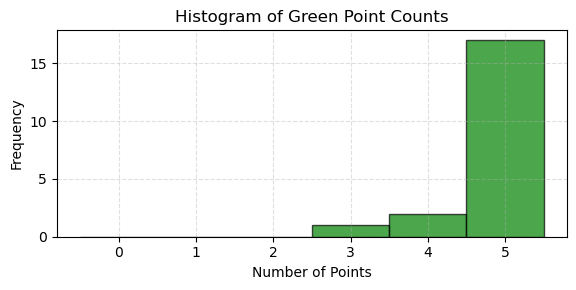

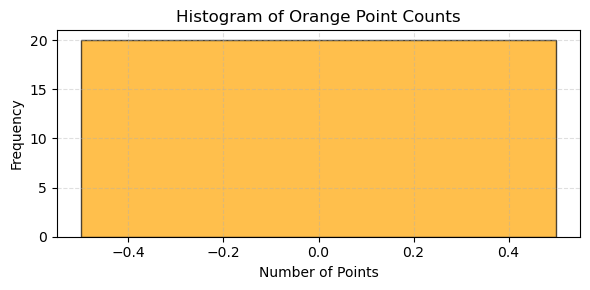

/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_18987/4091664289.py:185: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/kl/6hy0lk_14w14xqln8byr8l940000gn/T/ipykernel_18987/4091664289.py:185: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


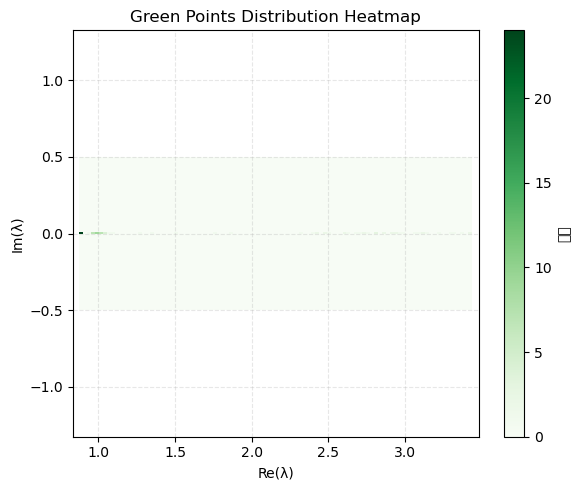

In [3]:
import numpy as np
import torch
import pandas as pd
from scipy.special import kv as besselk
from scipy.stats import gaussian_kde
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 8000, 2, 8, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
thresh_ext = alpha / alpha_c
delta = 0.15
jump_margin = 0.1

num_trials = 20
np.random.seed(42)
base_seeds = np.arange(0, 10000, step=500)[:num_trials]
noise = np.random.randint(0, 100, size=num_trials)
seeds = (base_seeds + noise).tolist()
print("使用的 seeds:", seeds)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 计数器与记录器 ==========
red_counter = defaultdict(int)
orange_counter = defaultdict(int)
green_counter = defaultdict(int)

green_count_list = []
orange_count_list = []
green_coords = []

# ✅ 新增：每轮绿色点落入两个跳脱区的数量
green_A_list = []
green_B_list = []

# ========== 单轮运行函数 ==========
def run_single_trial(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    W_star = torch.randn(d, p, device=device)
    X = torch.randn(n, d, device=device) / np.sqrt(d)
    Z = X @ W_star
    y = Z[:, 0] * Z[:, 1]

    y_np = y.detach().cpu().numpy()
    abs_y = np.abs(y_np)
    K0, K1 = besselk(0, abs_y), besselk(1, abs_y)
    lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
    lambda_y[np.isnan(lambda_y)] = 0

    G_y_np = np.zeros((n, p, p), dtype=np.float32)
    G_y_np[:, 0, 0] = lambda_y
    G_y_np[:, 1, 1] = lambda_y
    G_y_np[:, 0, 1] = y_np
    G_y_np[:, 1, 0] = y_np
    G_y = torch.tensor(G_y_np, device=device)

    XXT = X @ X.T
    XXT.fill_diagonal_(0.0)
    L_blocks = XXT[:, :, None, None] * G_y[None, :, :, :]
    L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)

    eigvals = torch.linalg.eigvals(L)
    eigvals_np = eigvals.detach().cpu().numpy().astype(np.complex128)

    eig_df = pd.DataFrame({
        "eig_idx": [f"eig{i}" for i in range(len(eigvals_np))],
        "eigval": eigvals_np,
        "Re": eigvals_np.real,
        "Im": eigvals_np.imag,
        "Abs": np.abs(eigvals_np)
    })

    # 红点
    red_pts = eig_df.sort_values(by="Re", ascending=False).head(2)
    for idx in red_pts["eig_idx"]:
        red_counter[idx] += 1

    # 橙点
    orange_mask = (eig_df["Re"] > thresh_ext) & (~eig_df["eig_idx"].isin(red_pts["eig_idx"]))
    orange_pts = eig_df[orange_mask]
    for idx in orange_pts["eig_idx"]:
        orange_counter[idx] += 1

    # 绿色点判断
    real_axis_re = eig_df.loc[np.abs(eig_df["Im"]) < 1e-6, "Re"].values
    if len(real_axis_re) >= 100:
        kde = gaussian_kde(real_axis_re)
        grid = np.linspace(np.min(real_axis_re), np.max(real_axis_re), 1024)
        density = kde(grid)
        pileup_center = grid[np.argmax(density)]
        jump_thresh = pileup_center + delta

        green_mask = (
            (np.abs(eig_df["Im"]) < 1e-6) &
            (eig_df["Abs"] < R) &
            (eig_df["Re"] > jump_thresh + jump_margin)
        )
        green_pts = eig_df[green_mask].sort_values(by="Re", ascending=False).head(5)
    else:
        green_pts = eig_df.iloc[[]]

    for idx in green_pts["eig_idx"]:
        green_counter[idx] += 1

    green_count_list.append(len(green_pts))
    orange_count_list.append(len(orange_pts))
    green_coords.extend(list(zip(green_pts["Re"], green_pts["Im"])))

    # ✅ 记录绿色点落入跳脱区 A/B 的数量
    green_A, green_B = 0, 0
    for re in green_pts["Re"]:
        if 0.95 <= re <= 1.05:
            green_A += 1
        elif 1.80 <= re <= 1.95:
            green_B += 1
    green_A_list.append(green_A)
    green_B_list.append(green_B)

# ========== 多轮运行 ==========
for seed in seeds:
    run_single_trial(seed)

# ========== 输出稳定点 ==========
def display_stable_points(counter_dict, label, threshold=2):
    filtered = [(k, v) for k, v in counter_dict.items() if v >= threshold]
    df = pd.DataFrame(filtered, columns=["eig_idx", "count"]).sort_values(by="count", ascending=False)
    print(f"\n【Stable {label} Points】(出现次数 ≥ {threshold})")
    if df.empty:
        print("无稳定谱点")
    else:
        print(df.to_string(index=False))

display_stable_points(red_counter, "Red", threshold=1)
display_stable_points(orange_counter, "Orange", threshold=1)
display_stable_points(green_counter, "Green", threshold=1)

# ========== 每轮绿色点数量直方分布 ==========
print("\n[绿色点数量直方分布 across trials]")
print(pd.Series(green_count_list).value_counts().sort_index().to_string())

print("\n[橙色点数量直方分布 across trials]")
print(pd.Series(orange_count_list).value_counts().sort_index().to_string())

# ✅ 每轮跳脱区 A / B 中绿色点数量分布
print("\n[跳脱区 A 中绿色点数量分布]")
print(pd.Series(green_A_list).value_counts().sort_index().to_string())

print("\n[跳脱区 B 中绿色点数量分布]")
print(pd.Series(green_B_list).value_counts().sort_index().to_string())

# ========== 可视化 ==========
def plot_histogram(counts, title, color):
    plt.figure(figsize=(6, 3))
    plt.hist(counts, bins=np.arange(-0.5, max(counts) + 1.5, 1), edgecolor='black', alpha=0.7, color=color)
    plt.title(title)
    plt.xlabel("Number of Points")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_histogram(green_count_list, "Histogram of Green Point Counts", "green")
plot_histogram(orange_count_list, "Histogram of Orange Point Counts", "orange")

# 绿色点热力图
def plot_green_point_heatmap(coords, bins=100):
    coords_np = np.array(coords)
    if len(coords_np) == 0:
        print("⚠️ 没有可用于绘图的绿色点数据")
        return
    x, y = coords_np[:, 0], coords_np[:, 1]
    plt.figure(figsize=(6, 5))
    plt.hist2d(x, y, bins=bins, cmap='Greens')
    plt.colorbar(label='频次')
    plt.xlabel("Re(λ)")
    plt.ylabel("Im(λ)")
    plt.title("Green Points Distribution Heatmap")
    plt.axis("equal")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_green_point_heatmap(green_coords)


你确认了在跳脱区 
[0.95,1.05] 内的绿色谱点在 Rayleigh 商上显著优于随机方向。

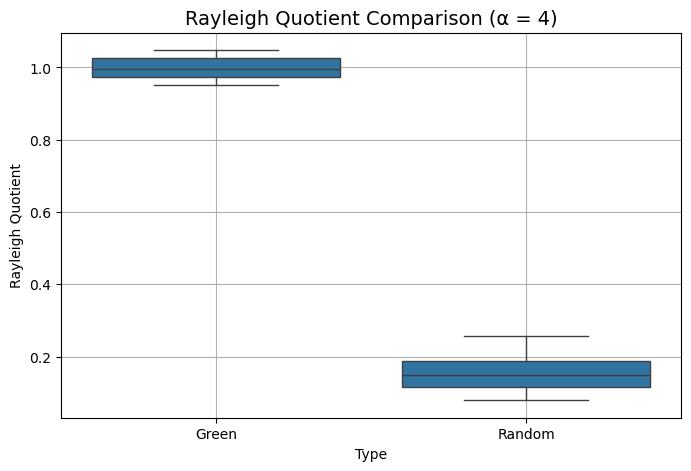

In [8]:
import numpy as np
import torch
from scipy.special import kv as besselk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 4, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 数据生成 ==========
torch.manual_seed(0)
np.random.seed(0)
W_star = torch.randn(d, p, device=device)
X = torch.randn(n, d, device=device) / np.sqrt(d)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ========== 构造 G(y) ==========
abs_y = torch.abs(y)
abs_y_np = abs_y.cpu().numpy()
K0 = torch.from_numpy(besselk(0, abs_y_np)).to(device)
K1 = torch.from_numpy(besselk(1, abs_y_np)).to(device)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[torch.isnan(lambda_y)] = 0

G_y = torch.zeros((n, p, p), device=device)
G_y[:, 0, 0] = lambda_y
G_y[:, 1, 1] = lambda_y

# ========== 构造谱矩阵 ==========
L = torch.zeros((p * d, p * d), device=device)
for i in range(n):
    xi = X[i].view(d, 1)
    xi_xt = xi @ xi.T                      # shape (d, d)
    L += torch.kron(G_y[i], xi_xt)         # shape (p*d, p*d)


# ========== 谱分解 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 绿色点筛选 ==========
real_parts = eigvals_np.real
green_mask = (real_parts > 0.95) & (real_parts < 1.05)
green_vecs = eigvecs_np[:, green_mask]

# ========== Rayleigh 商分析 ==========
L_np = L.cpu().numpy()
R_green = []
R_random = []

for v in green_vecs.T:
    R = (v.T @ L_np @ v) / np.linalg.norm(v) ** 2
    R_green.append(R.real)

for _ in range(len(R_green)):
    v = np.random.randn(p * d)
    v /= np.linalg.norm(v)
    R = (v.T @ L_np @ v)
    R_random.append(R)

# ========== 可视化 ==========
df = pd.DataFrame({
    'Rayleigh Quotient': R_green + R_random,
    'Type': ['Green'] * len(R_green) + ['Random'] * len(R_random)
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Type', y='Rayleigh Quotient')
plt.title(f'Rayleigh Quotient Comparison (α = {alpha})', fontsize=14)
plt.grid(True)
plt.show()


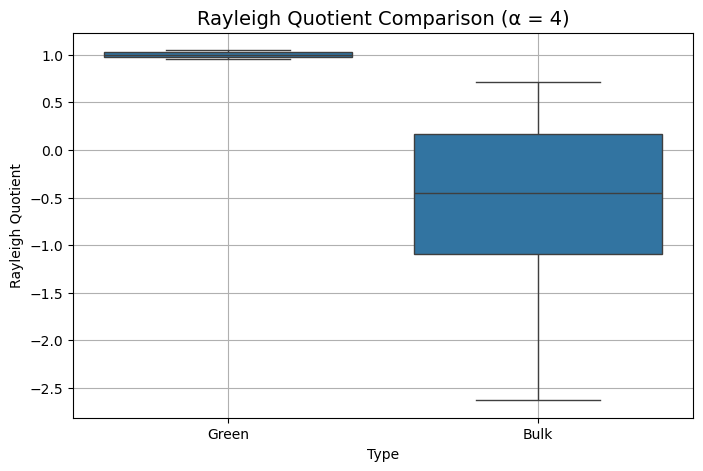

In [1]:
import numpy as np
import torch
from scipy.special import kv as besselk
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ========== 参数设置 ==========
n, p, alpha, alpha_c = 5000, 2, 4, 0.59375
d = int(n / alpha)
R = np.sqrt(alpha / alpha_c)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 数据生成 ==========
torch.manual_seed(0)
np.random.seed(0)
W_star = torch.randn(d, p, device=device)
X = torch.randn(n, d, device=device) / np.sqrt(d)
Z = X @ W_star
y = Z[:, 0] * Z[:, 1]

# ========== 构造 G(y) ==========
abs_y = torch.abs(y)
abs_y_np = abs_y.cpu().numpy()
K0 = torch.from_numpy(besselk(0, abs_y_np)).to(device)
K1 = torch.from_numpy(besselk(1, abs_y_np)).to(device)
lambda_y = abs_y * (K1 / (K0 + 1e-6)) - 1
lambda_y[torch.isnan(lambda_y)] = 0

G_y = torch.zeros((n, p, p), device=device)
G_y[:, 0, 0] = lambda_y
G_y[:, 1, 1] = lambda_y

# ========== 构造谱矩阵 ==========
L = torch.zeros((p * d, p * d), device=device)
for i in range(n):
    xi = X[i].view(d, 1)
    xi_xt = xi @ xi.T
    L += torch.kron(G_y[i], xi_xt)

# ========== 谱分解 ==========
eigvals, eigvecs = torch.linalg.eig(L)
eigvals_np = eigvals.cpu().numpy()
eigvecs_np = eigvecs.cpu().numpy()

# ========== 绿色点筛选 ==========
real_parts = eigvals_np.real
green_mask = (real_parts > 0.95) & (real_parts < 1.05)
green_vecs = eigvecs_np[:, green_mask]

# ========== Bulk 点筛选 ==========
# 假设 Bulk 在谱堆积带中心区，这里取 Re(λ) < 0.9
bulk_mask = (real_parts < 0.9)
bulk_vecs = eigvecs_np[:, bulk_mask]

# 随机选取与 Green 数量相同的 Bulk 向量
if bulk_vecs.shape[1] >= green_vecs.shape[1]:
    bulk_indices = np.random.choice(bulk_vecs.shape[1], green_vecs.shape[1], replace=False)
    bulk_vecs = bulk_vecs[:, bulk_indices]

# ========== Rayleigh 商分析 ==========
L_np = L.cpu().numpy()
R_green, R_bulk = [], []

for v in green_vecs.T:
    v = v / np.linalg.norm(v)
    R = (v.T @ L_np @ v) / np.linalg.norm(v) ** 2
    R_green.append(R.real)

for v in bulk_vecs.T:
    v = v / np.linalg.norm(v)
    R = (v.T @ L_np @ v) / np.linalg.norm(v) ** 2
    R_bulk.append(R.real)

# ========== 可视化 ==========
df = pd.DataFrame({
    'Rayleigh Quotient': R_green + R_bulk,
    'Type': ['Green'] * len(R_green) + ['Bulk'] * len(R_bulk)
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Type', y='Rayleigh Quotient')
plt.title(f'Rayleigh Quotient Comparison (α = {alpha})', fontsize=14)
plt.grid(True)
plt.show()
